<a href="https://www.youtube.com/watch?v=B7XgA0OmQl8&list=PLxqBkZuBynVS8mDTc8ZGermXiS-32pR2y&index=39&ab_channel=Rohan-Paul-AI"><h1 style="font-size:250%; font-family:cursive; color:#ff6666;"><b>Link YouTube Video - LGBM (LightGBM) Model on TimeSeries Data of Cryptocurrency Prices | Crypto with Machine Learning </b></h1></a>

[![IMAGE ALT TEXT](https://imgur.com/hwKdDxD.png)](https://www.youtube.com/watch?v=B7XgA0OmQl8&list=PLxqBkZuBynVS8mDTc8ZGermXiS-32pR2y&index=39&ab_channel=Rohan-Paul-AI)

### [Kaggle Competition Link](https://www.kaggle.com/competitions/g-research-crypto-forecasting/data)

-------------------------

In this exercise I will compare two LGBM baselines, 

 - one that considers each asset independently  (i.e. For each asset a Model File will be saved) and,
 - one multiple inputs that models all assets together (i.e. single Model File will be saved).

And in the competition, your predictions will be evaluated on a weighted version of the Pearson correlation coefficient, with weights given by the Weight column in the Asset Details file.

Note, that, for this competition, I can not check for Evalation of my Model's Prediction anymore with the Test Set data of this Competition, as the API for doing that is no more functional.

In [1]:
import os
import numpy as np
import pandas as pd

from tqdm.auto import tqdm
import joblib
import time
import datetime
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib_venn import venn2, venn3
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
sns.set_context("talk")
style.use('seaborn-colorblind')
from xgboost import XGBRegressor
import lightgbm as lgb

import warnings
warnings.simplefilter('ignore')



/tmp/ipykernel_18/2874710032.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-colorblind')


In [2]:
ROOT_DIR = '../input/'

# ROOT_DIR = '../input/g-research-crypto-forecasting/' # Kaggle Kernel

In [3]:
#This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#input :/kaggle/input
#output:/kaggle/working/
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crypto-nandanpr/train.csv
/kaggle/input/crypto-nandanpr-assets/asset_details.csv


# Config

In [4]:
class CFG:
    INPUT_DIR = ROOT_DIR
    OUTPUT_DIR = './'
    SEED = 20211103

<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> Reduce the memory footprint of this huge dataset</h3>
</div>

In [5]:
def get_optimal_numeric_type(c_min: float, c_max: float, col_type: str) -> str:
    """
    Determines the optimal numeric data type for a given range of values.

    Parameters
    ----------
    c_min : float
        The minimum value of the data.
    c_max : float
        The maximum value of the data.
    col_type : str
        The current data type of the column ('int' or 'float').

    Returns
    -------
    optimal_type : str
        The optimal data type for the given range of values.
    """
    type_info = np.iinfo if col_type == 'int' else np.finfo
    for dtype in [np.int8, np.int16, np.int32, np.int64, np.float16, np.float32, np.float64]:
        if col_type in str(dtype):
            if c_min > type_info(dtype).min and c_max < type_info(dtype).max:
                return dtype
    return None

""" Based on the data type and the range of values, the function determines the smallest possible data type that can accommodate the data without losing information. For example, if the data type is an integer and the range of values fits within the bounds of an int8 data type, the function converts the column data type to int8: """

def reduce_memory_usage(df: pd.DataFrame) -> pd.DataFrame:
    """
    Reduces memory usage of a pandas DataFrame by converting its columns to the most memory-efficient data types
    without losing information.

    Parameters
    ----------
    df : pd.DataFrame
        The input pandas DataFrame that needs memory optimization.

    Returns
    -------
    df : pd.DataFrame
        The optimized pandas DataFrame with reduced memory usage.
    """

    # Iterate through each column in the DataFrame
    df_copy = df.copy()
    for col in df_copy.columns:
        col_type = df_copy[col].dtype

        # Check if the data type is not an object (i.e., numeric type)
        if col_type != object:
            c_min, c_max = df_copy[col].min(), df_copy[col].max()
            col_type_str = 'int' if 'int' in str(col_type) else 'float'
            optimal_type = get_optimal_numeric_type(c_min, c_max, col_type_str)
            if optimal_type:
                df_copy[col] = df_copy[col].astype(optimal_type)
        # If the data type is an object, convert the column to a 'category' data type
        else:
            df_copy[col] = df_copy[col].astype('category')

    # Return the optimized DataFrame with reduced memory usage
    return df_copy

### Based on the data type and the range of values, the the above function determines the smallest possible data type that can accommodate the data without losing information. For example, if the data type is an integer and the range of values fits within the bounds of an int8 data type, the function converts the column data type to int8:

## train.csv - The training set

- timestamp - A timestamp for the minute covered by the row.
- Asset_ID - An ID code for the cryptoasset.
- Count - The number of trades that took place this minute.
- Open - The USD price at the beginning of the minute.
- High - The highest USD price during the minute.
- Low - The lowest USD price during the minute.
- Close - The USD price at the end of the minute.
- Volume - The number of cryptoasset units traded during the minute.
- VWAP - The volume weighted average price for the minute.
- Target - 15 minute residualized returns. See the ['Prediction and Evaluation' section of this notebook](https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition) for details of how the target is calculated.

In [6]:
before = pd.read_csv(os.path.join(CFG.INPUT_DIR, 'crypto-nandanpr/train.csv'))
before.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   Asset_ID   int64  
 2   Count      float64
 3   Open       float64
 4   High       float64
 5   Low        float64
 6   Close      float64
 7   Volume     float64
 8   VWAP       float64
 9   Target     float64
dtypes: float64(8), int64(2)
memory usage: 1.8 GB


In [7]:
%%time

train = pd.read_csv(os.path.join(CFG.INPUT_DIR, 'crypto-nandanpr/train.csv')).pipe(reduce_memory_usage)
print(train.shape)
train.head()

(24236806, 10)
CPU times: user 48 s, sys: 4.57 s, total: 52.6 s
Wall time: 52.6 s


,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.000000,2400.000000,2358.00000,2374.00000,19.233006,2373.116392,-0.004219
1,1514764860,0,5.0,8.531250,8.531250,8.53125,8.53125,78.379997,8.530000,-0.014397
2,1514764860,1,229.0,13832.000000,14016.000000,13664.00000,13848.00000,31.550062,13827.062093,-0.014641
3,1514764860,5,32.0,7.660156,7.660156,7.65625,7.65625,6626.713379,7.657713,-0.013924
4,1514764860,7,5.0,25.921875,25.921875,25.87500,25.87500,121.087311,25.891363,-0.008263


In [8]:
train.tail()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
24236801,1632182400,9,775.0,157.125000,157.250000,156.750000,157.000000,4.663726e+03,156.994319,NaN
24236802,1632182400,10,34.0,2438.000000,2438.000000,2430.000000,2432.000000,3.975460e+00,2434.818747,NaN
24236803,1632182400,13,380.0,0.091370,0.091553,0.091248,0.091370,2.193732e+06,0.091388,NaN
24236804,1632182400,12,177.0,0.282227,0.282471,0.281738,0.281982,1.828508e+05,0.282134,NaN
24236805,1632182400,11,48.0,232.750000,232.750000,232.250000,232.250000,1.035123e+02,232.569697,NaN


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int32  
 1   Asset_ID   int8   
 2   Count      float32
 3   Open       float16
 4   High       float16
 5   Low        float16
 6   Close      float16
 7   Volume     float32
 8   VWAP       float64
 9   Target     float16
dtypes: float16(5), float32(2), float64(1), int32(1), int8(1)
memory usage: 716.5 MB


## asset_details.csv 

Provides the real name and of the cryptoasset for each Asset_ID and **the weight each cryptoasset receives in the metric**.


In [10]:
asset_details = pd.read_csv(os.path.join(CFG.INPUT_DIR, 'crypto-nandanpr-assets/asset_details.csv'))
asset_details['Asset_ID'] = asset_details['Asset_ID'].astype(np.int8)
print(asset_details.shape)
asset_details

(14, 3)


,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


In [11]:
# dataframe info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int32  
 1   Asset_ID   int8   
 2   Count      float32
 3   Open       float16
 4   High       float16
 5   Low        float16
 6   Close      float16
 7   Volume     float32
 8   VWAP       float64
 9   Target     float16
dtypes: float16(5), float32(2), float64(1), int32(1), int8(1)
memory usage: 716.5 MB


In [12]:
train.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.000000,2400.000000,2358.00000,2374.00000,19.233006,2373.116392,-0.004219
1,1514764860,0,5.0,8.531250,8.531250,8.53125,8.53125,78.379997,8.530000,-0.014397
2,1514764860,1,229.0,13832.000000,14016.000000,13664.00000,13848.00000,31.550062,13827.062093,-0.014641
3,1514764860,5,32.0,7.660156,7.660156,7.65625,7.65625,6626.713379,7.657713,-0.013924
4,1514764860,7,5.0,25.921875,25.921875,25.87500,25.87500,121.087311,25.891363,-0.008263


In [13]:
# missing values?
train.isna().sum()

timestamp         0
Asset_ID          0
Count             0
Open              0
High              0
Low               0
Close             0
Volume            0
VWAP              9
Target       750338
dtype: int64

### [Source of the Upper and Lower Shadow calculations guideline](https://www.kaggle.com/code/cstein06/tutorial-to-the-g-research-crypto-competition/notebook)

<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> Feature Engineering</h3>
</div>

In [14]:
# select train and validation period

# auxiliary function, from datetime to timestamp
totimestamp = lambda s: np.int32(time.mktime(datetime.datetime.strptime(s, "%d/%m/%Y").timetuple()))

train_window = [totimestamp("01/01/2018"), totimestamp("01/06/2021")]

valid_window = [totimestamp("02/06/2020"), totimestamp("21/09/2021")]

train = train.set_index("timestamp")

beg_ = train.index[0].astype('datetime64[s]')
end_ = train.index[-1].astype('datetime64[s]')
""" taking the first and last index values and converting the retrieved index values into datetime objects with second precision. """

print('>> data goes from ', beg_, 'to ', end_, 'shape=', train.shape)

# drop rows without target
train.dropna(subset=['Target'], inplace=True)

# add train flag
train['train_flg'] = 1

train.loc[valid_window[0]:valid_window[1], 'train_flg'] = 0

>> data goes from  2018-01-01T00:01:00 to  2021-09-21T00:00:00 shape= (24236806, 9)


### Merge the Asset Details .csv file so I get the "Weights" for each of the Assets, which will be required for the evaluation parts

In [15]:
def merge_asset_details(train, asset_details):
    """Add asset details to train df
    """
    return train.merge(
        asset_details
        , how='left'
        , on='Asset_ID'
    )

# merge asset_details
train = merge_asset_details(train, asset_details)

In [16]:
train.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,train_flg,Weight,Asset_Name
0,2,40.0,2376.000000,2400.000000,2358.00000,2374.00000,19.233006,2373.116392,-0.004219,1,2.397895,Bitcoin Cash
1,0,5.0,8.531250,8.531250,8.53125,8.53125,78.379997,8.530000,-0.014397,1,4.304065,Binance Coin
2,1,229.0,13832.000000,14016.000000,13664.00000,13848.00000,31.550062,13827.062093,-0.014641,1,6.779922,Bitcoin
3,5,32.0,7.660156,7.660156,7.65625,7.65625,6626.713379,7.657713,-0.013924,1,1.386294,EOS.IO
4,7,5.0,25.921875,25.921875,25.87500,25.87500,121.087311,25.891363,-0.008263,1,2.079442,Ethereum Classic


In [17]:
def get_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extract additional features from the given DataFrame for financial analysis.
    
    Parameters
    ----------
    df : pd.DataFrame
        A pandas DataFrame containing the stock data with columns:
        'Open', 'High', 'Low', 'Close', 'Volume', and 'Count'.
    
    Returns
    -------
    df_copy : pd.DataFrame
        A new DataFrame with the extracted features as additional columns.
    """
    # Create a copy of the input DataFrame to avoid modifying the original data
    df_copy = df.copy()

    # Calculate the upper and lower shadows for the candlestick chart
    df_copy['upper_shadow'] = df_copy['High'] - np.maximum(df_copy['Close'], df_copy['Open'])
    df_copy['lower_shadow'] = np.minimum(df_copy['Close'], df_copy['Open']) - df_copy['Low']

    # Calculate the ratio of closing price to opening price
    df_copy['open2close'] = df_copy['Close'] / df_copy['Open']

    # Calculate the ratio of the highest price to the lowest price
    df_copy['high2low'] = df_copy['High'] / df_copy['Low']

    # Calculate the mean and median prices for each row
    mean_price = df_copy[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    median_price = df_copy[['Open', 'High', 'Low', 'Close']].median(axis=1)

    # Calculate the ratios of high and low prices to the mean and median prices
    df_copy['high2mean'] = df_copy['High'] / mean_price
    df_copy['low2mean'] = df_copy['Low'] / mean_price
    df_copy['high2median'] = df_copy['High'] / median_price
    df_copy['low2median'] = df_copy['Low'] / median_price

    # Calculate the ratio of volume to the count, adding 1 to avoid division by zero
    df_copy['volume2count'] = df_copy['Volume'] / (df_copy['Count'] + 1)

    return df_copy


In [18]:
%%time

feature_df = get_features(train)

print(feature_df.shape)
feature_df.tail()

(23486468, 21)
CPU times: user 24.3 s, sys: 3.24 s, total: 27.6 s
Wall time: 27.6 s


,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,train_flg,...,Asset_Name,upper_shadow,lower_shadow,open2close,high2low,high2mean,low2mean,high2median,low2median,volume2count
23486463,9,163.0,156.500000,156.625000,156.000000,156.125000,7.381963e+02,156.260253,-0.001154,0,...,Litecoin,0.125000,0.125000,0.997559,1.003906,1.001953,0.998535,1.001953,0.998535,4.501197
23486464,10,23.0,2420.000000,2420.000000,2412.000000,2414.000000,1.315794e+00,2417.326038,0.009834,0,...,Maker,0.000000,2.000000,0.997559,1.002930,1.001953,0.998535,1.001953,0.998535,0.054825
23486465,13,512.0,0.091003,0.091125,0.090820,0.090881,1.900696e+06,0.090943,0.004162,0,...,TRON,0.000122,0.000061,0.998535,1.002930,1.001953,0.998535,1.001953,0.998535,3705.059570
23486466,12,193.0,0.281006,0.281250,0.280273,0.280518,1.628699e+05,0.280655,0.000449,0,...,Stellar,0.000244,0.000244,0.998047,1.003906,1.001953,0.998047,1.001953,0.998047,839.535583
23486467,11,38.0,232.125000,232.250000,231.250000,231.625000,4.914804e+01,231.794078,0.002567,0,...,Monero,0.125000,0.375000,0.998047,1.003906,1.001953,0.997070,1.001953,0.997070,1.260206


In [19]:
feature_df.columns

Index(['Asset_ID', 'Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP',
       'Target', 'train_flg', 'Weight', 'Asset_Name', 'upper_shadow',
       'lower_shadow', 'open2close', 'high2low', 'high2mean', 'low2mean',
       'high2median', 'low2median', 'volume2count'],
      dtype='object')

<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> LightGBM </h3>
</div>



There are two ways to try out: full model (using all the crypto data at once) and individual model (model for each asset).

In [20]:
target = 'Target'

drops = ['timestamp', 'Asset_Name', 'Weight', 'train_flg', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']

features_selected_for_training = [f for f in train.columns if f not in drops + [target]]

categoricals = ['Asset_ID']

print('{:,} features_selected_for_training: {}'.format(len(features_selected_for_training), features_selected_for_training))

2 features_selected_for_training: ['Asset_ID', 'Count']


In [21]:
train.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,train_flg,Weight,Asset_Name
0,2,40.0,2376.000000,2400.000000,2358.00000,2374.00000,19.233006,2373.116392,-0.004219,1,2.397895,Bitcoin Cash
1,0,5.0,8.531250,8.531250,8.53125,8.53125,78.379997,8.530000,-0.014397,1,4.304065,Binance Coin
2,1,229.0,13832.000000,14016.000000,13664.00000,13848.00000,31.550062,13827.062093,-0.014641,1,6.779922,Bitcoin
3,5,32.0,7.660156,7.660156,7.65625,7.65625,6626.713379,7.657713,-0.013924,1,1.386294,EOS.IO
4,7,5.0,25.921875,25.921875,25.87500,25.87500,121.087311,25.891363,-0.008263,1,2.079442,Ethereum Classic


In [22]:
feature_df.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,train_flg,...,Asset_Name,upper_shadow,lower_shadow,open2close,high2low,high2mean,low2mean,high2median,low2median,volume2count
0,2,40.0,2376.000000,2400.000000,2358.00000,2374.00000,19.233006,2373.116392,-0.004219,1,...,Bitcoin Cash,24.0,16.0,0.999023,1.017578,1.008789,0.991699,1.009766,0.992188,0.469098
1,0,5.0,8.531250,8.531250,8.53125,8.53125,78.379997,8.530000,-0.014397,1,...,Binance Coin,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.063333
2,1,229.0,13832.000000,14016.000000,13664.00000,13848.00000,31.550062,13827.062093,-0.014641,1,...,Bitcoin,168.0,168.0,1.000977,1.025391,1.012695,0.987305,1.012695,0.987305,0.137174
3,5,32.0,7.660156,7.660156,7.65625,7.65625,6626.713379,7.657713,-0.013924,1,...,EOS.IO,0.0,0.0,0.999512,1.000977,1.000977,1.000000,1.000977,1.000000,200.809494
4,7,5.0,25.921875,25.921875,25.87500,25.87500,121.087311,25.891363,-0.008263,1,...,Ethereum Classic,0.0,0.0,0.998047,1.001953,1.000977,0.999023,1.000977,0.999023,20.181219


In [23]:
feature_df.tail()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,train_flg,...,Asset_Name,upper_shadow,lower_shadow,open2close,high2low,high2mean,low2mean,high2median,low2median,volume2count
23486463,9,163.0,156.500000,156.625000,156.000000,156.125000,7.381963e+02,156.260253,-0.001154,0,...,Litecoin,0.125000,0.125000,0.997559,1.003906,1.001953,0.998535,1.001953,0.998535,4.501197
23486464,10,23.0,2420.000000,2420.000000,2412.000000,2414.000000,1.315794e+00,2417.326038,0.009834,0,...,Maker,0.000000,2.000000,0.997559,1.002930,1.001953,0.998535,1.001953,0.998535,0.054825
23486465,13,512.0,0.091003,0.091125,0.090820,0.090881,1.900696e+06,0.090943,0.004162,0,...,TRON,0.000122,0.000061,0.998535,1.002930,1.001953,0.998535,1.001953,0.998535,3705.059570
23486466,12,193.0,0.281006,0.281250,0.280273,0.280518,1.628699e+05,0.280655,0.000449,0,...,Stellar,0.000244,0.000244,0.998047,1.003906,1.001953,0.998047,1.001953,0.998047,839.535583
23486467,11,38.0,232.125000,232.250000,231.250000,231.625000,4.914804e+01,231.794078,0.002567,0,...,Monero,0.125000,0.375000,0.998047,1.003906,1.001953,0.997070,1.001953,0.997070,1.260206


# LGBM Configurations

In [24]:
params = {
        'n_estimators': 10000,
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'max_depth': -1,
        'learning_rate': 0.01,
        'subsample': 0.72,
        'subsample_freq': 4,
        'feature_fraction': 0.4,
        'lambda_l1': 1,
        'lambda_l2': 1,
        'seed': 46,
        }

Note again that what we are doing in this exercise is that - Compare two LGBM baselines, one that considers each asset independently and one multiple inputs that models all assets together.

<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> Train Full Model (i.e. a single Model File will be saved) </h3>
</div>



In [25]:
def train_lgbm_model(feature_df, features_selected_for_training, target, categoricals, params):
    """
    Train an LGBM model on the given feature DataFrame, save the model and return feature importances.
    
    Parameters
    ----------
    feature_df : pd.DataFrame
        DataFrame containing the features_selected_for_training and target variable
    features_selected_for_training : list of str
        List of feature names used for training the model
    target : str
        Name of the target variable
    categoricals : list of str
        List of categorical feature names
    params : dict
        Dictionary of parameters for the LGBM model
    output_dir : str
        Directory to save the trained model
    
    Returns
    -------
    fi_df : pd.DataFrame
        DataFrame containing the feature importances
    """
    
    # Instantiate the LGBM model
    model = lgb.LGBMRegressor(**params)

    # Fit the model on the training data and validate on the validation data
    model.fit(
        feature_df.query('train_flg == 1')[features_selected_for_training],
        feature_df.query('train_flg == 1')[target].values, 
        eval_set=[(feature_df.query('train_flg == 0')[features_selected_for_training]
                   , feature_df.query('train_flg == 0')[target].values)],
        #verbose=-1, 
        #{'verbose': -1},
        #early_stopping_rounds=100,
        callbacks=[
        lgb.early_stopping(stopping_rounds=100),
           ],
        categorical_feature=categoricals,
    )
    
    return model


In [26]:
model = train_lgbm_model(feature_df, features_selected_for_training, target, categoricals, params)

# save model
joblib.dump(model, os.path.join(CFG.OUTPUT_DIR, 'lgb_model_val.pkl'))

print('LGBM model saved to output dir')

# feature importance
fi_df = pd.DataFrame()
fi_df['features_selected_for_training'] = features_selected_for_training
fi_df['importance'] = model.booster_.feature_importance(importance_type="gain")



[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.103821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 269
[LightGBM] [Info] Number of data points in the train set: 14158842, number of used features: 2


<Axes: xlabel='importance', ylabel='features_selected_for_training'>

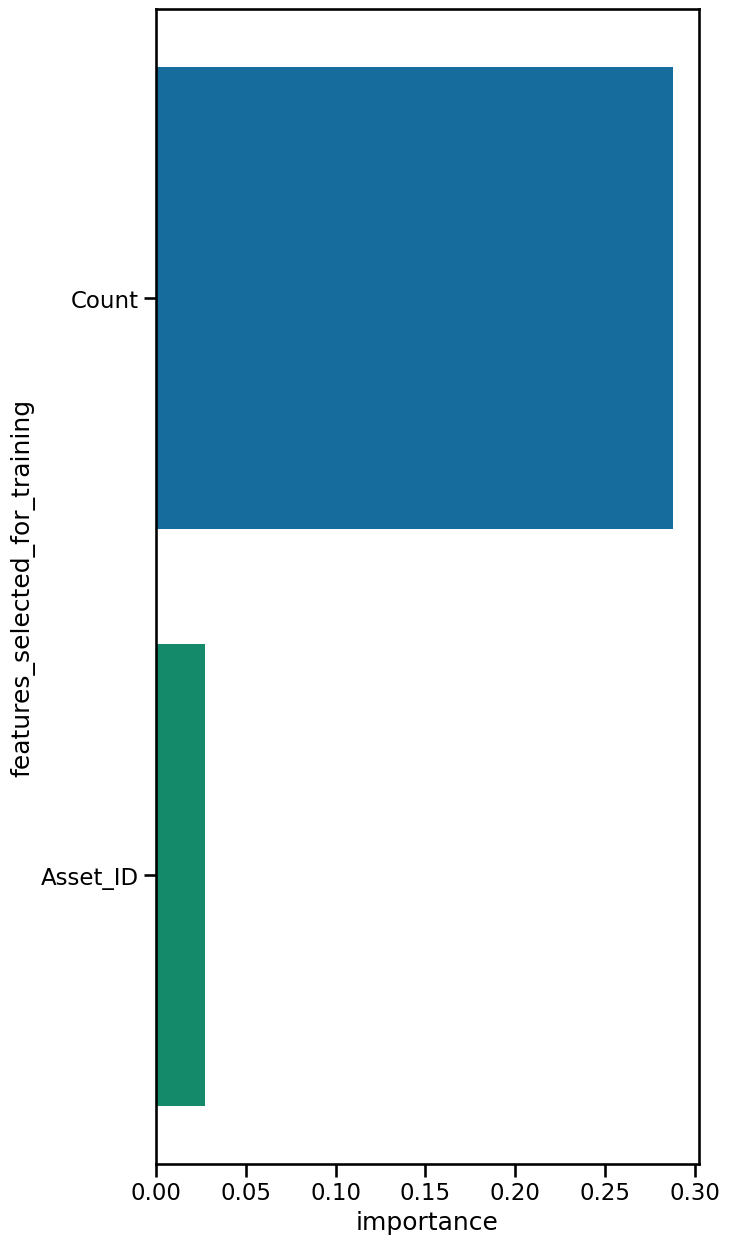

In [27]:
# plot feature importance
fig, ax = plt.subplots(1, 1, figsize=(7, 15))
sns.barplot(
    x='importance'
    , y='features_selected_for_training'
    , data=fi_df.sort_values(by=['importance'], ascending=False)
    , ax=ax
)

<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> Train Individual Model (i.e. For each asset a Model File will be saved) </h3>
</div>

In [28]:
def train_lgbm_model_for_asset(asset, feature_df, features_selected_for_training, target, params, output_dir):
    """
    Train an LGBM model on the given feature DataFrame for a specific asset, and save the model.
    
    Parameters
    ----------
    asset : int
        Asset_ID for which the model is trained
    feature_df : pd.DataFrame
        DataFrame containing the features and target variable
    features_selected_for_training : list of str
        List of selected feature names used for training the model
    target : str
        Name of the target variable
    params : dict
        Dictionary of parameters for the LGBM model
    output_dir : str
        Directory to save the trained model
    """

    # Instantiate the LGBM model
    model = lgb.LGBMRegressor(**params)

    # Train the model on the specific asset and validate
    train_data = feature_df.query('train_flg == 1 and Asset_ID == @asset')
    val_data = feature_df.query('train_flg == 0 and Asset_ID == @asset')
    
    model.fit(
        train_data[features_selected_for_training],
        train_data[target].values, 
        eval_set=[(val_data[features_selected_for_training], val_data[target].values)],
        verbose=-1, 
        early_stopping_rounds=100,
    )
    
    # Save the model
    asset_name = train_data['Asset_Name'].values[0]
    model_path = os.path.join(output_dir, f'lgb_model_{asset_name}_val.pkl')
    joblib.dump(model, model_path)
    print(f'lgb model for {asset_name} saved!')

# Train LGBM models for each asset
for asset in feature_df['Asset_ID'].unique():
    train_lgbm_model_for_asset(asset, feature_df, features_selected_for_training, target, params, CFG.OUTPUT_DIR)


TypeError: LGBMRegressor.fit() got an unexpected keyword argument 'verbose'

<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> Evaluation score - weighted correlation </h3>
</div>



In the competition, your predictions will be evaluated on a weighted version of the Pearson correlation coefficient, with weights given by the Weight column in the Asset Details file.

Note, that, for this competition, I can not check for Evalation of my Model's Prediction anymore with the Test Set data of this Competition, as the API for doing that is no more functional.

### Hence below below methods, which follows the competition-metric of "weighted correlation" evaluates our Model's Prediction on our seperately kept validation set

---------------------------------

## Weighted Covariance

Weighted covariance is a measure of how much two variables change together, considering the weight of each data point. The formula for weighted covariance is:

# $$Cov(x, y, w) = Σ(w_i * (x_i - μ_x) * (y_i - μ_y)) / Σw_i$$

where:

* x and y are the two variables (data arrays) for which we are calculating covariance.

* w is the weight array, which represents the importance of each data point.

* μ_x and μ_y are the weighted means of x and y, respectively, calculated as Σ(x_i * w_i) / Σw_i and Σ(y_i * w_i) / Σw_i.

* Σ denotes the sum of the elements.

* i represents the index of each data point in the arrays.

----------------

### The formula for weighted correlation is:

## $$ρ(x, y, w) = Cov(x, y, w) / sqrt(Cov(x, x, w) * Cov(y, y, w))$$

where:

* x and y are the two variables (data arrays) for which we are calculating correlation.

* w is the weight array, which represents the importance of each data point.

* Cov(x, y, w) is the weighted covariance between x and y

In [ ]:
def weighted_mean(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(prediction, target, w):
    """Weighted Covariance"""
    return np.sum(w * (prediction - weighted_mean(prediction, w)) * (target - weighted_mean(target, w))) / np.sum(w)

""" (prediction - weighted_mean(prediction, w)) * (target - weighted_mean(target, w))

This calculate the differences between each data point and their respective weighted means. 
These differences are then element-wise multiplied by the weight array w. """

def corr(prediction, target, w):
    """Weighted Correlation"""
    return cov(prediction, target, w) / np.sqrt(cov(prediction, prediction, w) * cov(target, target, w))


<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> Evaluating the Full Model </h3>
</div>

In [ ]:

# Compute the correlation
print('Load the FULL MODEL *******************************************')

model = joblib.load(os.path.join(CFG.OUTPUT_DIR, 'lgb_model_val.pkl'))

val_df = train.query('train_flg == 0').copy()

val_df['Prediction'] = model.predict(val_df[features_selected_for_training])

for asset in val_df['Asset_ID'].unique():
    tmp = val_df.query('Asset_ID == @asset')
    coin = tmp['Asset_Name'].values[0]
    
    r = corr(tmp['Prediction'], tmp['Target'], tmp['Weight'])
    
    print('')
    
    print('- {}: Validation Score (weighted correlation) = {:.4f}'.format(coin, r))

r = corr(val_df['Prediction'], val_df['Target'], val_df['Weight'])

print('=> Overall Validation Score (weighted correlation) = {:.4f}'.format(r))

In [ ]:
val_df.head(10)

```
FULL MODEL *******************************************

- Cardano: Validation Score (weighted correlation) = 0.0295

- Bitcoin Cash: Validation Score (weighted correlation) = 0.0089

- Binance Coin: Validation Score (weighted correlation) = 0.0116

- Bitcoin: Validation Score (weighted correlation) = -0.0247

- Dogecoin: Validation Score (weighted correlation) = 0.0409

- EOS.IO: Validation Score (weighted correlation) = -0.0058

- Ethereum Classic: Validation Score (weighted correlation) = 0.0221

- Ethereum: Validation Score (weighted correlation) = 0.0198

- IOTA: Validation Score (weighted correlation) = -0.0004

- Litecoin: Validation Score (weighted correlation) = 0.0020

- Maker: Validation Score (weighted correlation) = 0.0203

- TRON: Validation Score (weighted correlation) = -0.0125

- Stellar: Validation Score (weighted correlation) = 0.0097

- Monero: Validation Score (weighted correlation) = -0.0153
=> Overall Validation Score (weighted correlation) = 0.0130
```

In [ ]:
asset_name = feature_df.query('Asset_ID == @asset')['Asset_Name'].values[0]

* .query(): This is a method provided by pandas for querying a DataFrame using a boolean expression. It allows you to filter rows in the DataFrame based on the condition specified in the query string.

* @asset: The @ symbol is used in the query string to reference a variable from the surrounding context (Python environment). This allows you to use variables in your query string instead of hardcoding the values.
  
In this case, it refers to the variable asset that has been declared in the immediately preceeding line

```
for asset in val_df['Asset_ID'].unique():
```

<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> Evaluating the Individual Models </h3>
</div>

In [ ]:
print('INDIVIDUAL MODEL *******************************************')
val_df['Prediction'] = 0
for asset in val_df['Asset_ID'].unique():
    asset_name = feature_df.query('Asset_ID == @asset')['Asset_Name'].values[0]
    # load model
    model = joblib.load(os.path.join(CFG.OUTPUT_DIR, 'lgb_model_{}_val.pkl'.format(asset_name)))
    
    # inference
    val_df.loc[val_df['Asset_ID'] == asset, 'Prediction'] = model.predict(val_df.loc[val_df['Asset_ID'] == asset, features_selected_for_training])
    # Explanation of => vmodel.predict(val_df.loc[val_df['Asset_ID'] == asset, features_selected_for_training])
    # The loc function is a label-based indexer that allows you to select rows and columns by their labels. 
    # Essentially, this line selects all the rows where the 'Asset_ID' matches the 'asset' variable.
    # And then => ..., features_selected_for_training: => This part specifies the columns to be selected from the filtered DataFrame. 
    # So 'features_selected_for_training" is a list of column names that you want to keep in the output. So overall, The loc function will return only these columns for the selected rows.
    
    tmp = val_df.query('Asset_ID == @asset')
    
    asset_name = tmp['Asset_Name'].values[0]
    
    r = corr(tmp['Prediction'], tmp['Target'], tmp['Weight'])
    
    print('')
    
    print('- {}: Validation Score (weighted correlation) = {:.4f}'.format(asset_name, r))
    
r = corr(val_df['Prediction'], val_df['Target'], val_df['Weight'])
print('=> Overall Validation Score (weighted correlation) = {:.4f}'.format(r))

## So looks like individual model suffers, hence for submitting the to Kaggle Competition, better to stick with the full model

In [ ]:
# train (full model)
params['n_estimators'] = 101
model = lgb.LGBMRegressor(**params)
model.fit(
    feature_df[features_selected_for_training],
    feature_df[target].values, 
    verbose=-1, 
    categorical_feature=categoricals,
)

# save model
joblib.dump(model, 'lgb_model_final.pkl')
print('lgb model saved!')

## But the above model, I can not check for Evalation with the Test Set data of this Competition, as the API for doing that is no more functional.